# Draw polar plots for all categories

In [409]:
# See this for the list of valid ones https://pastebin.com/NGzvE0Ky
interesting_categories = [
#    ('VISp', [175, 185, 205], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Slc17a7-IRES2-Cre']),
#    ('VISp', [275, 335, 350], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Rorb-IRES2-Cre', 'Scnn1a-Tg3-Cre']),
#    ('VISp', [375, 390, 400], ['Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Fezf2-CreER', 'Rbp4-Cre_KL100', 'Tlx3-Cre_PL56'])
#    ('VISp', [550], ['Ntsr1-Cre_GN220'])
#    ('VISp', [175, 185, 195, 200, 225, 275], ['Pvalb-IRES-Cre'])
#    ('VISp', [175, 275], ['Vip-IRES-Cre'])
#    ('VISp', [265, 285, 350], ['Sst-IRES-Cre'])
#    ('VISal', [175, 265] ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre'] 
#    ('VISal', [275], ['Sst-IRES-Cre']),
#    ('VISal', [275, 276, 300, 350], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Rorb-IRES2-Cre', 'Nr5a1-Cre'])
#    ('VISal', [365, 375], ['Emx1-IRES-Cre', 'Rbp4-Cre_KL100']),
#    ('VISam', [175], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre'])
#    ('VISam', [275, 320, 325, 350], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Rorb-IRES2-Cre', 'Nr5a1-Cre'])
#    ('VISam', [375], ['Emx1-IRES-Cre', 'Rbp4-Cre_KL100'])
#    ('VISl', [175], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre'])
#    ('VISl', [275, 325, 350], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Rorb-IRES2-Cre', 'Nr5a1-Cre'])
#    ('VISl', [375, 400], ['Fezf2-CreER', 'Rbp4-Cre_KL100', 'Tlx3-Cre_PL56 ', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Rorb-IRES2-Cre', 'Nr5a1-Cre'])
#    ('VISl', [550, 570, 625], ['Ntsr1-Cre_GN220'])
#    ('VISl', [175, 250, 275], ['Vip-IRES-Cre'])
#    ('VISl', [250, 275], ['Sst-IRES-Cre'])
#    ('VISl', [375], ['Sst-IRES-Cre'])
#    ('VISpm', [175], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre'])
#    ('VISpm', [275, 300, 325, 335, 350], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Rorb-IRES2-Cre', 'Nr5a1-Cre'])
#    ('VISpm', [550], ['Ntsr1-Cre_GN220'])
#    ('VISpm', [175, 275], ['Vip-IRES-Cre'])
#    ('VISpm', [275, 300, 325, 350, 375], ['Sst-IRES-Cre'])
#    ('VISrl', [175], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre'])
#    ('VISrl', [275, 350], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Rorb-IRES2-Cre', 'Nr5a1-Cre'])
#    ('VISrl', [375], ['Rbp4-Cre_KL100 ', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre'])
    ('VISrl', [375], ['Sst-IRES-Cre']),
]
    
dsi_dg_threshold = 0.5

In [410]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'
    
import warnings; warnings.simplefilter('ignore');
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
from utils.data_wrappers import *
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

In [411]:
get_one_category_polar_data_cache = {}

In [412]:
def get_avg_cell_polar_in_experiment(boc, ec_id, exp_id, cells):
    """
    Get the polar data for all cells in this experiment, then average them out to get a single polar data.
    """
    in_category_cells = cells[cells.experiment_container_id == ec_id]
    dg_response_filter = get_dg_response_filter_from_saskia()
    filtered_cells = get_filtered_cells(in_category_cells, dg_response_filter)
    filtered_cells = filtered_cells[filtered_cells.dsi_dg > dsi_dg_threshold]
    print ("In this experiment, we have", len(in_category_cells),
           "cells, but after filtering, we have", len(filtered_cells), "cells")
    
    thetas = []
    rs = []
    cell_ids = []
    for ii, row in filtered_cells.iterrows():
        cell_specimen_id = row.cell_specimen_id
        pref_tf = row.pref_tf
        one_cell_polar_data_dict = get_avg_normalized_response(
            boc=boc,
            session_id=exp_id,
            cell_specimen_id = cell_specimen_id,
            temporal_frequency=pref_tf)
        if one_cell_polar_data_dict is None:
            continue
        theta, r = convert_polar_dict_to_arrays(one_cell_polar_data_dict)
        thetas.append(theta)
        rs.append(r)
        cell_ids.append(cell_specimen_id)
        
    print ("In this experiment, we have", len(in_category_cells),
           "cells, but after filtering and removing negative mean dffs, we have", len(thetas), "cells")
    if len(thetas) == 0:
        return None, None, None
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    return agg_theta, agg_r, len(thetas)

In [413]:
def get_one_category_polar_data(boc, targeted_structure, imaging_depths, cre_lines):
    cache_key = (targeted_structure, tuple(imaging_depths), tuple(cre_lines))
    if cache_key in get_one_category_polar_data_cache:
        return get_one_category_polar_data_cache[cache_key]
    
    exps = boc.get_ophys_experiments(stimuli=[stim_info.DRIFTING_GRATINGS],
        targeted_structures = [targeted_structure],
        imaging_depths = imaging_depths,
        cre_lines = cre_lines)
    if len(exps) == 0:
        return None, None, None, None
    print ("There are", len(exps), "experiments for ", targeted_structure, imaging_depths, cre_lines)
    
    thetas = []
    rs = []
    total_num_cells = 0
    for exp in exps:
        e_id = exp['id']
        ec_id = exp['experiment_container_id']
        print("Processing experiment", e_id)
        theta, r, num_cells = get_avg_cell_polar_in_experiment(boc, ec_id, e_id, cells)
        if theta is None or len(theta) == 0:
            continue
        thetas.append(theta)
        rs.append(r)
        total_num_cells += num_cells
        
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    
    if len(thetas) == 0:
        agg_theta, agg_r, thetas, rs, total_num_cells= None, None, None, None, None
    
    get_one_category_polar_data_cache[cache_key] = (agg_theta, agg_r, thetas, rs, total_num_cells)
    return get_one_category_polar_data_cache[cache_key]


There are 1 experiments for  VISrl [375] ['Sst-IRES-Cre']
Processing experiment 589755795
In this experiment, we have 9 cells, but after filtering, we have 2 cells
In this experiment, we have 9 cells, but after filtering and removing negative mean dffs, we have 2 cells
VISrl [375] ['Sst-IRES-Cre'] #Experiments:  1 #Cells: 2


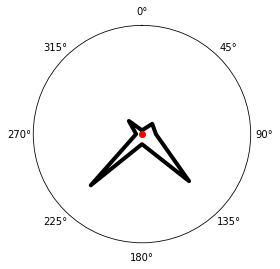

In [414]:
import warnings; warnings.simplefilter('ignore');
for targeted_structure, imaging_depths, cre_lines in interesting_categories:
    agg_theta, agg_r, thetas, rs, num_cells = get_one_category_polar_data(
        boc,
        targeted_structure,
        imaging_depths,
        cre_lines)
    if agg_theta is None:
        continue
    print(targeted_structure, imaging_depths, cre_lines, "#Experiments: ", len(thetas), "#Cells:", num_cells)
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
    polar_plot_population(ax=ax,
        bold_theta = agg_theta,
        bold_r = agg_r,
        grey_thetas = thetas, 
        grey_rs = rs)
    plt.show()